<a href="https://colab.research.google.com/github/Jieoi/traffic_sign_recognition/blob/main/model_training_simple_enhanced_data_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Note: This instance of Google Colab has been configured to use T4 GPU. It is possible to run all other sections at a slower rate on CPU.

Note: The code below has been configured to run on Google colab with python scripts and data imported from google drive. Please download the scripts and data from [here](https://drive.google.com/drive/folders/1nViTcpc952b0ftRGqkDBFqbSEC01t0a8). Files required including all scripts and helper files under data_preparation folder and data_augmentation folder. Alternatively, vist my github repository to [download](https://github.com/Jieoi/traffic_sign_recognition/tree/main) the scripts and helper files.

<h1> 2.1 Data Preparation for Machine Learning</h1>

<h2>2.1.1 Preparing the notebook</h2>

The first step is to connect to Google Drive so that the data enhanced in the previouse notebook can be used.

The exact files that the notebook needs to  access are <code>final_image.zip</code> and <code>image_data.csv</code>. It can be found in the link <a href="https://drive.google.com/drive/folders/1nViTcpc952b0ftRGqkDBFqbSEC01t0a8">here</a>.

Ideally, the notebook should be run in Google Colab with high RAM and GPU support. However, the code can be excuted on CPU only mode with a longer training time.

In [ ]:
# Checking GPU availability
!nvidia-smi

Tue Sep  5 10:11:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


The libraries used in this notebook are listed below.

In [ ]:
# Zip file handling
import zipfile
import os

# Data handling and visualization
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# File handling and management for training and validation data
from shutil import copyfile
from sklearn.model_selection import train_test_split

# importing library for ML processing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# CNN layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Regularization
from tensorflow.keras import regularizers

# Saving the model
from tensorflow.keras.models import save_model

# Metrics for evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score

<h2>2.1.2 Data preparation for Machine Learning</h2>

Firstly, pre-porcessed training data is obtained and prepared for machine learning:


The labels for all the images is in the <code>image_data.csv</code> file. It is first extracted in the code below.

In [ ]:
csv_file = '/content/drive/MyDrive/final/train_data/image_data2.csv'

# Read the CSV file into a pandas DataFrame
df_classes = pd.read_csv(csv_file)
df_classes.info

<bound method DataFrame.info of        class      filename
0          0       0_0.png
1          0       0_1.png
2          0       0_2.png
3          0       0_3.png
4          0       0_4.png
...      ...           ...
26655     42  42_26655.png
26656     42  42_26656.png
26657     42  42_26657.png
26658     42  42_26658.png
26659     42  42_26659.png

[26660 rows x 2 columns]>

Then the images are extracted from the <code>final_image.zip</code> file.

In [ ]:
# Paths
zip_file_path = '/content/drive/MyDrive/final/train_data/final_image.zip'
extracted_dir = '/content/extracted_images'

# Create the directory for extracted images if it doesn't exist
os.makedirs(extracted_dir, exist_ok=True)


# Open the ZIP file and extract its contents
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# Check the length of the extracted images
num_extracted_images = len(os.listdir(extracted_dir))
print(f"Number of extracted images: {num_extracted_images}")
print("Extraction completed.")

Number of extracted images: 26660
Extraction completed.


Both images and there labels extracted contains the same number of entries.

The distribution of the final classes is shown below.

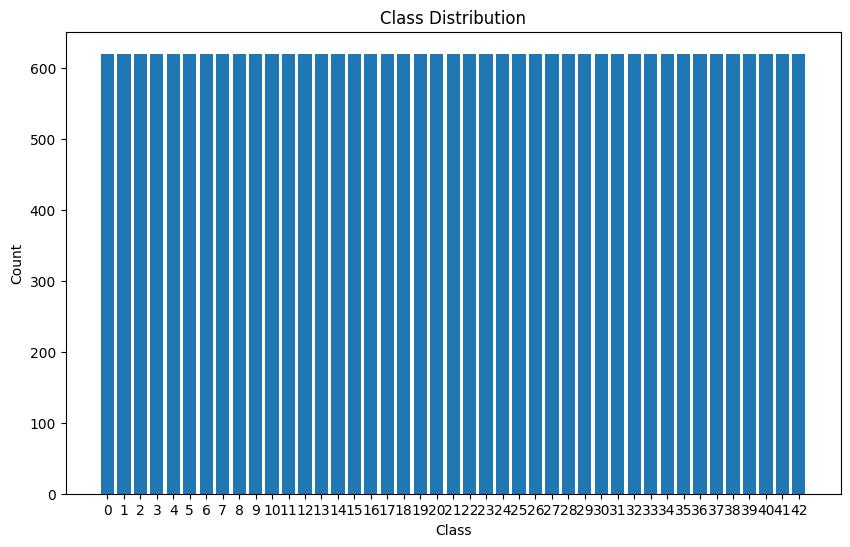

In [ ]:
# Count the occurrences of each class in the DataFrame
class_counts = df_classes['class'].value_counts()

# Sort the unique class IDs
unique_classes = np.sort(df_classes['class'].unique())

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(unique_classes, class_counts[unique_classes])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(unique_classes)
plt.show()

Both images are first split into training and validation sets. They are grouped by their classes and stored in individual directories for every classes.

In [ ]:
train_dir = '/content/train_images'
valid_dir = '/content/valid_images'

# Create directories for training and validation images
os.makedirs(train_dir, exist_ok=True)
os.makedirs(valid_dir, exist_ok=True)

# Split the data into training and validation sets
train_df, valid_df = train_test_split(df_classes, test_size=0.2, random_state=42, stratify=df_classes['class'])

# Copy images to directories based on classes for training set
for index, row in train_df.iterrows():
    src_path = os.path.join(extracted_dir, row['filename'])
    dst_path = os.path.join(train_dir, str(row['class']), row['filename'])
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    copyfile(src_path, dst_path)

# Copy images to directories based on classes for validation set
for index, row in valid_df.iterrows():
    src_path = os.path.join(extracted_dir, row['filename'])
    dst_path = os.path.join(valid_dir, str(row['class']), row['filename'])
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    copyfile(src_path, dst_path)

print("Data preparation for ML completed.")

Data preparation for ML completed.


<h1> 2.2 Machine Learning</h1>

<h2>2.2.1 Data pipeline</h2>

<code>flow_from_directory()</code> from Keras ImageDataGenerator is used to load the images with rescaling to 1/255. batch size and image size are pre-set to 32 and (128, 128), respectively.

In [ ]:
# Define paths
train_dir = '/content/train_images'
valid_dir = '/content/valid_images'

# Define image dimensions and batch size
image_size = (30,30)
batch_size = 32

# Create data generators and rescale image for ML on training and validation
train_datagen = ImageDataGenerator(rescale=1.0/255)
valid_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True  # Set shuffle to True for training data
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for validation data
)

# Get the number of classes from the training generator
num_classes = len(train_generator.class_indices)

Found 21328 images belonging to 43 classes.
Found 5332 images belonging to 43 classes.


Next, the test data is also obtained and prepared for machine learning.

In [ ]:
# Define the paths
test_zip_path = '/content/drive/MyDrive/final/test_data/test_image_simple.zip'
test_extracted_dir = '/content/extracted_test_images'
test_dir = '/content/test_images'

# Create the directory for extracted test images if it doesn't exist
os.makedirs(test_extracted_dir, exist_ok=True)

# Open the ZIP file and extract its contents
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(test_extracted_dir)

In [ ]:
# Move the test images to the test directory while renaming them with their true labels
for filename in os.listdir(test_extracted_dir):
    src_path = os.path.join(test_extracted_dir, filename)
    # Extract the true label from the filename (before the underscore)
    true_label = filename.split('_')[0]
    dst_path = os.path.join(test_dir, true_label, filename)
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    copyfile(src_path, dst_path)

In [ ]:
# Create a data generator for the test data
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Set shuffle to False for testing data
)

Found 12630 images belonging to 43 classes.


<h2>2.2.2 Training the CNN model</h2>

Double checking the GPU availability and set the GPU device if it is available

In [ ]:
# Check GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Specify GPU device
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


A function is defined to plot the training history

In [ ]:
def calculate_accuracy_increase_rate(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    train_rate = np.mean(np.diff(train_accuracy))
    val_rate = np.mean(np.diff(val_accuracy))

    return train_rate, val_rate

In [ ]:
def plot_training_history(history):
    # Access the training history
    training_loss = history.history['loss']
    training_accuracy = history.history['accuracy']
    validation_loss = history.history['val_loss']
    validation_accuracy = history.history['val_accuracy']

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Plotting the training and validation accuracy
    ax1.plot(training_accuracy)
    ax1.plot(validation_accuracy)
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Train', 'Validation'], loc='upper left')

    # Plotting the training and validation loss
    ax2.plot(training_loss)
    ax2.plot(validation_loss)
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'], loc='upper right')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the figure
    plt.show()

In [ ]:
# Get true labels from the test generator
true_labels = test_generator.classes

# Get unique true labels
class_names = [str(label) for label in range(43)]

<h2> Model 1: Simple CNN baseline</h2>


Training the CNN model to upto 30 epochs, early stopping is used to prevent overfitting. However, no regularization is applied.

In [ ]:
# Define the CNN layers
input_layer = Input(shape=(30, 30, 3))
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Create the model
model_CNN = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_CNN.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_CNN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 30, 30, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 128)         73856 

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
num_epochs = 30
history_simpleCNN = model_CNN.fit(train_generator, epochs=num_epochs, validation_data=valid_generator, callbacks=[early_stopping])

print("Model training completed.")

Epoch 1/30
667/667 [==============================] - 38s 40ms/step - loss: 2.3641 - accuracy: 0.3243 - val_loss: 1.0312 - val_accuracy: 0.6785
Epoch 2/30
667/667 [==============================] - 25s 37ms/step - loss: 0.9147 - accuracy: 0.7074 - val_loss: 0.5911 - val_accuracy: 0.8078
Epoch 3/30
667/667 [==============================] - 21s 32ms/step - loss: 0.5878 - accuracy: 0.8120 - val_loss: 0.4636 - val_accuracy: 0.8518
Epoch 4/30
667/667 [==============================] - 12s 18ms/step - loss: 0.4499 - accuracy: 0.8552 - val_loss: 0.3430 - val_accuracy: 0.8850
Epoch 5/30
667/667 [==============================] - 13s 20ms/step - loss: 0.3549 - accuracy: 0.8838 - val_loss: 0.2977 - val_accuracy: 0.9021
Epoch 6/30
667/667 [==============================] - 12s 18ms/step - loss: 0.2987 - accuracy: 0.9008 - val_loss: 0.3096 - val_accuracy: 0.9012
Epoch 7/30
667/667 [==============================] - 12s 17ms/step - loss: 0.2536 - accuracy: 0.9150 - val_loss: 0.2380 - val_accuracy:

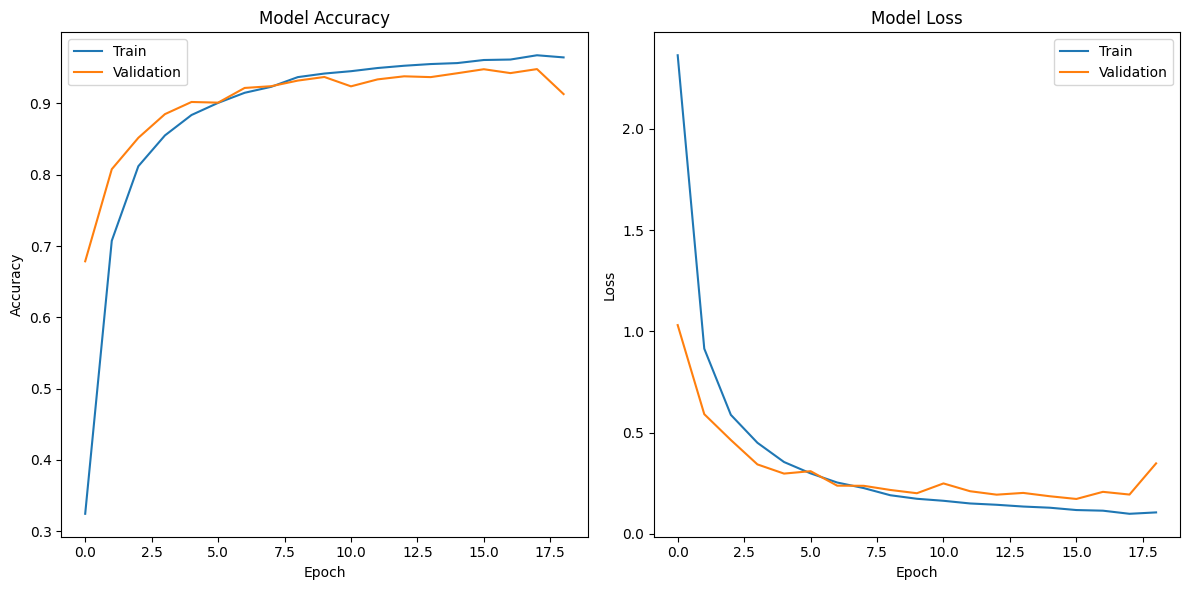

In [ ]:
plot_training_history(history_simpleCNN)

In [ ]:
# Increasing rate
train_rate_SCNN, val_rate_SCNN = calculate_accuracy_increase_rate(history_simpleCNN)
print("Training Accuracy Increase Rate:", train_rate_SCNN)
print("Validation Accuracy Increase Rate:", val_rate_SCNN)

Training Accuracy Increase Rate: 0.03557660182317098
Validation Accuracy Increase Rate: 0.013034509287940131


In [ ]:
# Test the model with the test data
test_loss_SCNN, test_accuracy_SCNN = model_CNN.evaluate(test_generator)

print(f"Test Loss: {test_loss_SCNN:.4f}")
print(f"Test Accuracy: {test_accuracy_SCNN:.4f}")

395/395 [==============================] - 10s 24ms/step - loss: 0.8925 - accuracy: 0.8432
Test Loss: 0.8925
Test Accuracy: 0.8432


In [ ]:
# Make predictions on the test data
test_pred_SCNN = model_CNN.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
pred_labels_SCNN = np.argmax(test_pred_SCNN, axis=1)

# Calculate the precision score
precision_SCNN = precision_score(true_labels, pred_labels_SCNN, average='weighted')

print(f"Precision Score: {precision_SCNN:.4f}")

395/395 [==============================] - 9s 23ms/step
Precision Score: 0.8583


In [ ]:
# Generate a classification report
class_rep_SCNN = classification_report(true_labels, pred_labels_SCNN, target_names=class_names)

print("Classification Report:\n", class_rep_SCNN)

Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.30      0.32        60
           1       0.88      0.83      0.86       720
           2       0.96      0.89      0.92       660
           3       0.90      0.88      0.89       420
           4       0.99      0.99      0.99       690
           5       0.99      0.99      0.99       720
           6       0.94      0.99      0.97       270
           7       0.73      0.89      0.80       210
           8       0.86      1.00      0.92       150
           9       0.99      0.93      0.95       360
          10       0.92      0.63      0.75       390
          11       0.38      0.80      0.52        60
          12       0.75      0.88      0.81       750
          13       0.49      0.72      0.58        90
          14       0.36      0.16      0.22        90
          15       0.60      0.88      0.72       120
          16       0.65      0.83      0.73       150
   

<h2> Model 2: More complex CNN with regularization</h2>



More complexity is added to the CNN model with regularization added:

Added more convolutional layers with increasing filters to capture more complex features.
Added batch normalization layers after each convolutional and dense layer to help stabilize training.
Added an additional dense layer with dropout and batch normalization.

In [ ]:
# Define the CNN layers
input_layer = Input(shape=(30, 30, 3))
x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)

# Create the model
model_complex = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with a lower learning rate
model_complex.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model_complex.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 30, 30, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 28, 28, 64)        1792      
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 batch_normalization_4 (Batc  (None, 12, 12, 128)      512 

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with data augmentation and early stopping
num_epochs = 50
history_complex_model = model_complex.fit(train_generator, epochs=num_epochs, validation_data=valid_generator, callbacks=[early_stopping])

print("Model training completed.")

Epoch 1/50
667/667 [==============================] - 17s 21ms/step - loss: 10.7636 - accuracy: 0.4068 - val_loss: 8.6901 - val_accuracy: 0.7234
Epoch 2/50
667/667 [==============================] - 14s 21ms/step - loss: 7.7293 - accuracy: 0.7066 - val_loss: 6.5958 - val_accuracy: 0.8243
Epoch 3/50
667/667 [==============================] - 14s 21ms/step - loss: 5.8884 - accuracy: 0.8181 - val_loss: 5.0850 - val_accuracy: 0.8856
Epoch 4/50
667/667 [==============================] - 14s 20ms/step - loss: 4.5157 - accuracy: 0.8819 - val_loss: 3.9387 - val_accuracy: 0.9113
Epoch 5/50
667/667 [==============================] - 14s 20ms/step - loss: 3.4781 - accuracy: 0.9132 - val_loss: 3.0561 - val_accuracy: 0.9261
Epoch 6/50
667/667 [==============================] - 14s 20ms/step - loss: 2.6707 - accuracy: 0.9375 - val_loss: 2.3903 - val_accuracy: 0.9312
Epoch 7/50
667/667 [==============================] - 16s 24ms/step - loss: 2.0576 - accuracy: 0.9542 - val_loss: 1.8590 - val_accuracy

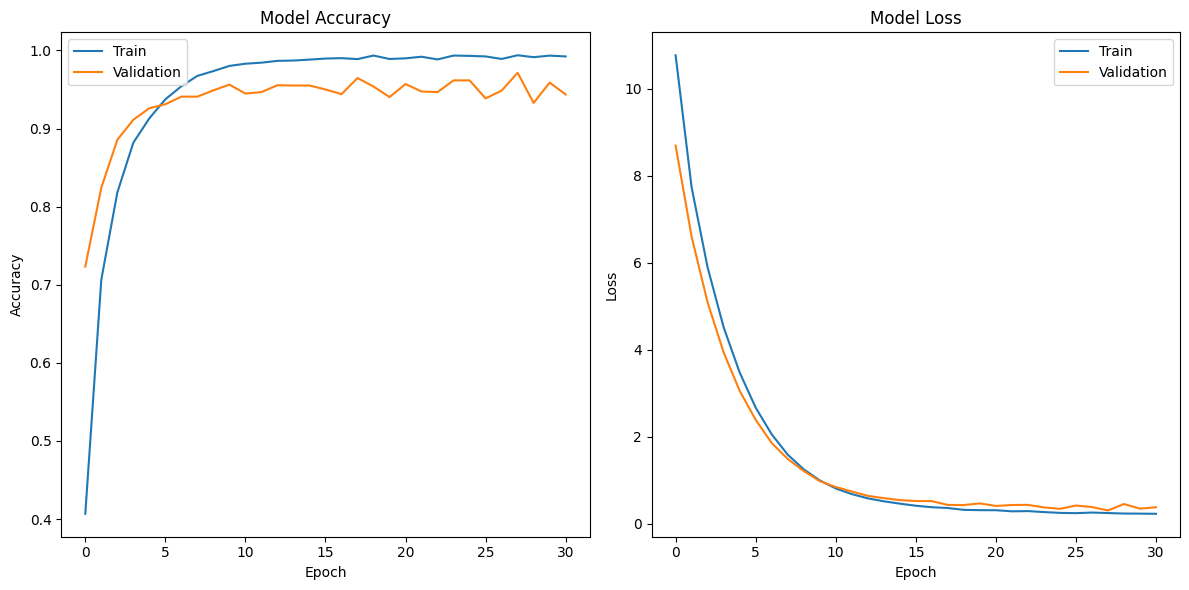

In [ ]:
plot_training_history(history_complex_model)

In [ ]:
# Increasing rate
train_rate_complex, val_rate_complex = calculate_accuracy_increase_rate(history_complex_model)
print("Training Accuracy Increase Rate:", train_rate_complex)
print("Validation Accuracy Increase Rate:", val_rate_complex)

Training Accuracy Increase Rate: 0.01952050526936849
Validation Accuracy Increase Rate: 0.0073455870151519775


In [ ]:
# Test the model with the test data
test_loss_complex, test_accuracy_complex = model_complex.evaluate(test_generator)

print(f"Test Loss: {test_loss_complex:.4f}")
print(f"Test Accuracy: {test_accuracy_complex:.4f}")

395/395 [==============================] - 11s 28ms/step - loss: 0.7780 - accuracy: 0.8582
Test Loss: 0.7780
Test Accuracy: 0.8582


In [ ]:
# Make predictions on the test data
test_pred_complex = model_complex.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_labels_complex = np.argmax(test_pred_complex, axis=1)

# Calculate the precision score
precision_complex = precision_score(true_labels, predicted_labels_complex, average='weighted')

print(f"Precision Score: {precision_complex:.4f}")

395/395 [==============================] - 11s 27ms/step
Precision Score: 0.8843


In [ ]:
# Generate a classification report
class_rep_complex = classification_report(true_labels, predicted_labels_complex, target_names=class_names)

print("Classification Report:\n", class_rep_complex)

Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.70      0.60        60
           1       0.97      0.80      0.88       720
           2       1.00      0.86      0.92       660
           3       0.92      0.93      0.93       420
           4       0.95      1.00      0.97       690
           5       0.99      0.99      0.99       720
           6       0.99      0.92      0.95       270
           7       0.78      0.93      0.85       210
           8       0.96      1.00      0.98       150
           9       0.96      0.98      0.97       360
          10       0.98      0.62      0.76       390
          11       0.58      0.88      0.70        60
          12       0.91      0.81      0.86       750
          13       0.65      0.81      0.72        90
          14       0.94      0.52      0.67        90
          15       0.82      0.88      0.85       120
          16       0.80      0.69      0.74       150
   

<h2> Model 3: Even more complex CNN with regularization and more layers</h2>

In [ ]:
# Define the CNN layers
input_layer = Input(shape=(30, 30, 3))
x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)

x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)
# Create the model
model_more_complex = Model(inputs=input_layer, outputs=output_layer)

# Compile the model with a lower learning rate
model_more_complex.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model_more_complex.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 30, 30, 3)]       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 28, 28, 64)        1792      
                                                                 
 batch_normalization_22 (Bat  (None, 28, 28, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 14, 14, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 12, 12, 128)       73856     
                                                                 
 batch_normalization_23 (Bat  (None, 12, 12, 128)      512 

In [ ]:
# Compile the model with a lower learning rate
model_more_complex.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
num_epochs = 50
history_more_complex_model = model_more_complex.fit(train_generator, epochs=num_epochs, validation_data=valid_generator, callbacks=[early_stopping])

print("Model training completed.")

Epoch 1/50
667/667 [==============================] - 18s 23ms/step - loss: 10.4645 - accuracy: 0.4272 - val_loss: 8.3528 - val_accuracy: 0.7140
Epoch 2/50
667/667 [==============================] - 15s 22ms/step - loss: 7.2973 - accuracy: 0.7176 - val_loss: 6.1316 - val_accuracy: 0.8380
Epoch 3/50
667/667 [==============================] - 13s 19ms/step - loss: 5.3985 - accuracy: 0.8265 - val_loss: 4.6169 - val_accuracy: 0.8742
Epoch 4/50
667/667 [==============================] - 13s 19ms/step - loss: 4.0231 - accuracy: 0.8776 - val_loss: 3.4398 - val_accuracy: 0.9104
Epoch 5/50
667/667 [==============================] - 13s 19ms/step - loss: 2.9605 - accuracy: 0.9182 - val_loss: 2.5850 - val_accuracy: 0.9261
Epoch 6/50
667/667 [==============================] - 12s 18ms/step - loss: 2.1902 - accuracy: 0.9434 - val_loss: 1.9633 - val_accuracy: 0.9269
Epoch 7/50
667/667 [==============================] - 12s 19ms/step - loss: 1.6407 - accuracy: 0.9560 - val_loss: 1.4911 - val_accuracy

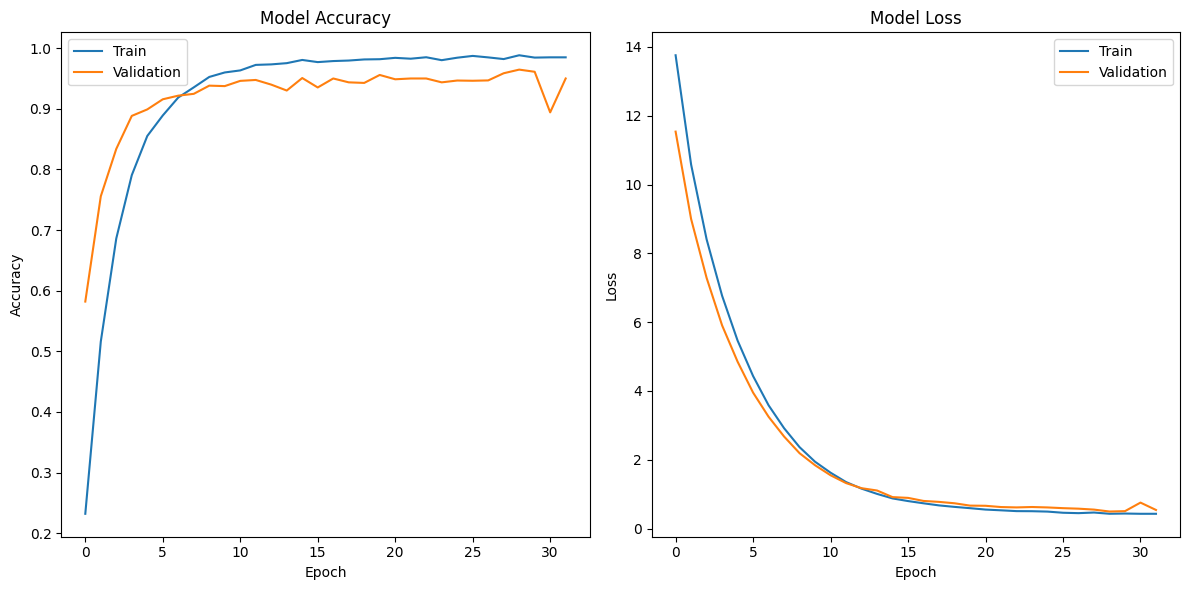

In [ ]:
plot_training_history(history_more_complex_model)

In [ ]:
# Increasing rate
train_rate_mComplex, val_rate_mComplex = calculate_accuracy_increase_rate(history_more_complex_model)
print("Training Accuracy Increase Rate:", train_rate_mComplex)
print("Validation Accuracy Increase Rate:", val_rate_mComplex)

Training Accuracy Increase Rate: 0.014534883774243869
Validation Accuracy Increase Rate: 0.006352549944168482


In [ ]:
# Test the model with the test data
test_loss_mComplex, test_accuracy_mComplex = model_more_complex.evaluate(test_generator)

print(f"Test Loss: {test_loss_mComplex:.4f}")
print(f"Test Accuracy: {test_accuracy_mComplex:.4f}")

395/395 [==============================] - 11s 27ms/step - loss: 0.7019 - accuracy: 0.8594
Test Loss: 0.7019
Test Accuracy: 0.8594


In [ ]:
# Make predictions on the test data
test_pred_mComplex = model_more_complex.predict(test_generator)

# Convert one-hot encoded predictions back to class labels
predicted_labels_mComplex = np.argmax(test_pred_mComplex, axis=1)

# Calculate the precision score
precision_mComplex = precision_score(true_labels, predicted_labels_mComplex, average='weighted')

print(f"Precision Score: {precision_mComplex:.4f}")

395/395 [==============================] - 9s 21ms/step
Precision Score: 0.8786


In [ ]:
# Generate a classification report
class_rep_mComplex = classification_report(true_labels, predicted_labels_mComplex, target_names=class_names)

print("Classification Report:\n", class_rep_mComplex)

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.68      0.68        60
           1       0.87      0.92      0.89       720
           2       0.99      0.95      0.97       660
           3       0.88      0.93      0.90       420
           4       0.99      0.97      0.98       690
           5       0.98      0.99      0.98       720
           6       1.00      0.94      0.97       270
           7       0.58      0.88      0.70       210
           8       0.93      0.99      0.96       150
           9       0.99      0.96      0.97       360
          10       0.94      0.71      0.81       390
          11       0.56      0.72      0.63        60
          12       0.76      0.87      0.81       750
          13       0.38      0.82      0.52        90
          14       0.80      0.18      0.29        90
          15       0.63      0.83      0.72       120
          16       0.63      0.69      0.66       150
   

<h1> 2.3 Saving the model</h1>

In [ ]:
model.save("final_CNN_model.h5")

In [ ]:
def save_training_history(history, filename):
    # Create a DataFrame from the training history
    history_df = pd.DataFrame(history.history)

    # Save the DataFrame to a CSV file
    history_df.to_csv(filename, index=False)

    # Print the first few rows of the history DataFrame
    print(history_df.head())

In [ ]:
save_training_history(history_simpleCNN, 'training_history_simpleCNN.csv')

In [ ]:
save_training_history(history_normCNN, 'training_history_normCNN.csv')

In [ ]:
import shutil
import os

# Define the destination directory in Google Drive
dest_dir = '/content/drive/MyDrive/final/training_models/CNN/'

# Create the destination directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# Define the source paths
src_paths = [
    'final_CNN_model.h5',
    'training_history_simpleCNN.csv',
    'training_history_normCNN.csv',
]

# Copy files to Google Drive
for src_path in src_paths:
    shutil.copy(src_path, dest_dir)

print("Files copied to Google Drive successfully.")